We start with importing the necessarry modules

In [1]:
import re
from io import StringIO
import csv
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

wordbagDictionary shows at which position a certain feature is in the wordBag. 
It holds a unique value for each word so that it's identifiable in the wordBag.
LABELMAP maps the labels to numbers. PRINT_RESULTS_FOR_SINGLE_RUN is just there for debug options. If we set it to true, all the results and plots for training every classifier are printed

In [2]:
word_bag_dictionary = {}
word_bag = []

LABELMAP = {
    "INCOME": 1,
    "LIVING": 2,
    "PRIVATE": 3,
    "STANDARDOFLIVING": 4,
    "LEISURE": 5,
    "FINANCE": 6,
    "TRAFFIC": 7
}

PRINT_RESULTS_FOR_SINGLE_RUN = True
CLASSIFICATOR_COLORS = { "Gaussian": "red", "Multinomial" :"blue", "Bernoulli": "green"}

In [3]:
def read_csv(file, debug = False):
    csvfile = open(file, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    content = list(reader)
    # Remove header
    content.pop(0)
    return content

We need a set of all the tokens that appear in the document. These three functions iterate through the content of the csv file, remove digits and non-word characters and return a list of all the tokens.

In [4]:
def remove_special_characters_and_numbers(str):
    str = re.sub('[\W_]+', '', str)
    str = re.sub('[\d_]+', '', str)
    return str;

def split_text(text, count_duplicates = False):
    unprocessed_tokens = text.split(' ')
    if count_duplicates == False:
        unprocessed_tokens = set(unprocessed_tokens)

    processed_tokens = []
    for token in unprocessed_tokens:
        token = token.upper()
        token = remove_special_characters_and_numbers(token)
        processed_tokens.append(token)
    return processed_tokens

def extract_all_tokens(csv_content, count_duplicates = False):
    all_tokens = []
    for line in csv_content:
		#line[4] = Buchungstext, line[5] = Verwendungszweck, line[6] = Begünstigter
        tokens = split_text(line[4] + " " + line[5] + " " + line[6], count_duplicates)
        all_tokens.append(tokens)
    return all_tokens

Now that we have all the tokens, we can fill our wordBagDictionary that we defined as module variables. The word_bag holds every 

In [5]:
def create_word_bag_and_dictionary(all_tokens):
    for token_line in all_tokens:
        for token in token_line:
            if token == '':
                continue
            if token not in word_bag_dictionary:
                word_bag.append(token)
                word_bag_dictionary[token] = len(word_bag) - 1

The bag of words is ready to use, let's create our feature matrix! It will look like this:
[[0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0,
  0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
  0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0]]
This function creates the feature matrix just for the features we extracted. We will add a label column later on, that's why we preserve one extra column for it. The label is mapped to an integer value, the get_label_nr function will get the right number.

In [6]:
def create_feature_matrix(csv_content, all_tokens):
    feature_matrix = []
    for tokens_in_row_x in all_tokens:
        # +1 because we still need to add the label later on
        feature_matrix.append([0] * (len(word_bag) + 1))
        for token in tokens_in_row_x:
            if token == '':
                continue
            pos = word_bag_dictionary[token]
            feature_matrix[len(feature_matrix)-1][pos] += 1
    feature_matrix = add_labels(csv_content, feature_matrix)
    return feature_matrix

def get_label_nr(label_name):
    return LABELMAP.get(label_name, -1)

def add_labels(csv_content, feature_matrix):
    i = 0
    for line in csv_content:
        feature_matrix[i][len(feature_matrix[i])-1] = get_label_nr(line[11].upper())
        i += 1
    return feature_matrix

Our feature matrix is ready to use. The only thing we have to do left is split our features in training and test samples. We can use a ratio as parameter to specify how much percentage of training and testing data we want to have. 0.8 for example means 80 percent training and 20 percent testing data.

In [7]:
# Function taken from https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
def split_dataset(dataset, split_ratio):
    train_size = int(len(dataset) * split_ratio)
    train_set = []
    copy = list(dataset)
    while len(train_set) < train_size:
        index = random.randrange(len(copy))
        train_set.append(copy.pop(index))
    return [train_set, copy]

In [8]:
#return a tuple which contains the training data, the corresponding labels and the test data
def get_classification_ready_data(percentage_of_training_data):
    """Returns a tuple of training data, training labels, test data and test labels
    Test labels are just returned for evaluating how good the classification worked
    """
    csv_content = read_csv('Exercise 1 - Transaction Classification - Data Set.csv')
    all_tokens = extract_all_tokens(csv_content, True)
    create_word_bag_and_dictionary(all_tokens)
    feature_matrix = create_feature_matrix(csv_content, all_tokens)

    training_data_with_labels, test_data = split_dataset(feature_matrix, percentage_of_training_data)
    training_data_with_labels = numpy.array(training_data_with_labels).astype(numpy.float)
    test_data = numpy.array(test_data).astype(numpy.float)

    test_labels = test_data[:,-1]
    # remove labels
    test_data = numpy.delete(test_data, len(test_data[0]) - 1, axis=1)
    training_labels = training_data_with_labels[:,-1]
    # remove labels
    training_data = numpy.delete(training_data_with_labels, len(training_data_with_labels[0]) - 1, axis=1)
    return training_data, training_labels, test_data, test_labels

We want some nice plots to visualize the performance of a classifier. We need two plots. One should visualize the performance of a single classification result, e. g. one run for training and testing the Gaussian Classifier. We need another one though that visualizes the performance of the whole process, of all epochs. For making it clearer, here's an example calculalation.
$$Accuracy = \frac{\sum{\text{Correct classified test samples}}}{\sum{\text{All samples}}}$$

$$Performance = \frac{1}{nm} \sum_{i=0}^{n=10}{\sum_{j=0}^{m=5}{Accuracy_{i,j}}}$$

Given the following results for a GaussianNB Classificator:

Run 1: 55% = 0.94, 60% = 0.92, 65% = 0.91, 70% = 0.95, 75% = 0.94

Run 2: 55% = 0.83, 60% = 0.91, 65% = 0.89, 70% = 0.90, 75% = 0.95

Run 3: 55% = 0.94, 60% = 0.88, 65% = 0.88, 70% = 0.91, 75% = 0.93

The final performance of the Gaussian Naive Bayes would be

$$Accuracy_1 = \frac{1}{5} (0.94 + 0.92 + 0.91 + 0.95 + 0.94) = 0.932$$
$$Accuracy_2 = \frac{1}{5} (0.83 + 0.91 + 0.89 + 0.90 + 0.95) = 0.896$$
$$Accuracy_3 = \frac{1}{5} (0.94 + 0.88 + 0.88 + 0.91 + 0.93) = 0.908$$

$$Performance = \frac{1}{3} (0.932 + 0.896 + 0.908) = 0.912$$


In [9]:
def plot_classification_results(plot_data_classification):
    fig, ax = plt.subplots()
    for key, value in plot_data_classification.items():
        training_data_percentage_X = value[:,0]
        accuracy_percentage_Y = value[:,1]
        ax.scatter(training_data_percentage_X, accuracy_percentage_Y, marker='o', color=CLASSIFICATOR_COLORS[key], label=key)

    ax.set(xlabel='training data (%)', ylabel='accuracy (%)',
           title='Accuracy with increasing percentage of the training data')
    ax.legend()
    ax.grid()
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()
    
def print_results_of_all_runs(plot_data):
    last_x_entries = 5
    D = {}
    for classificator_name, results_classificators in plot_data.items():
        performance_classificator = 0
        for result_single_run_classificator in results_classificators:  
            performance_classificator += numpy.sum(result_single_run_classificator[-last_x_entries:,-1])
        performance_classificator = performance_classificator / last_x_entries / len(results_classificators)
        D[classificator_name] = performance_classificator
    
    for key, value in D.items():
        print("Performance " + key + ": " + str(D[key]))

All the functions that are needed for preprocessing the data are implemented. Now we can just fetch the data and give them to the scikit naive bayes classifier. We calculate the correct classifications, the missclassifications and the accuracy. 

Run: 1
Gaussian
Training data in percent: 0.05	Correct: 75	Incorrect: 124	Accuracy: 0.38
Training data in percent: 0.05	Correct: 107	Incorrect: 92	Accuracy: 0.54
Training data in percent: 0.05	Correct: 101	Incorrect: 98	Accuracy: 0.51
Training data in percent: 0.05	Correct: 108	Incorrect: 91	Accuracy: 0.54
Training data in percent: 0.05	Correct: 92	Incorrect: 107	Accuracy: 0.46
Training data in percent: 0.05	Correct: 115	Incorrect: 84	Accuracy: 0.58
Training data in percent: 0.05	Correct: 106	Incorrect: 93	Accuracy: 0.53
Training data in percent: 0.05	Correct: 84	Incorrect: 115	Accuracy: 0.42
Training data in percent: 0.05	Correct: 93	Incorrect: 106	Accuracy: 0.47
Training data in percent: 0.05	Correct: 83	Incorrect: 116	Accuracy: 0.42
Training data in percent: 0.10	Correct: 148	Incorrect: 41	Accuracy: 0.78
Training data in percent: 0.15	Correct: 146	Incorrect: 32	Accuracy: 0.82
Training data in percent: 0.20	Correct: 141	Incorrect: 27	Accuracy: 0.84
Training data in percent: 0.25	Corr

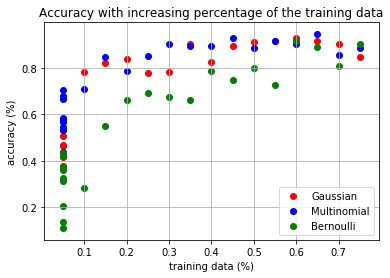

Run: 2
Gaussian
Training data in percent: 0.05	Correct: 91	Incorrect: 108	Accuracy: 0.46
Training data in percent: 0.05	Correct: 102	Incorrect: 97	Accuracy: 0.51
Training data in percent: 0.05	Correct: 138	Incorrect: 61	Accuracy: 0.69
Training data in percent: 0.05	Correct: 104	Incorrect: 95	Accuracy: 0.52
Training data in percent: 0.05	Correct: 76	Incorrect: 123	Accuracy: 0.38
Training data in percent: 0.05	Correct: 118	Incorrect: 81	Accuracy: 0.59
Training data in percent: 0.05	Correct: 115	Incorrect: 84	Accuracy: 0.58
Training data in percent: 0.05	Correct: 126	Incorrect: 73	Accuracy: 0.63
Training data in percent: 0.05	Correct: 130	Incorrect: 69	Accuracy: 0.65
Training data in percent: 0.05	Correct: 103	Incorrect: 96	Accuracy: 0.52
Training data in percent: 0.10	Correct: 124	Incorrect: 65	Accuracy: 0.66
Training data in percent: 0.15	Correct: 152	Incorrect: 26	Accuracy: 0.85
Training data in percent: 0.20	Correct: 144	Incorrect: 24	Accuracy: 0.86
Training data in percent: 0.25	Corr

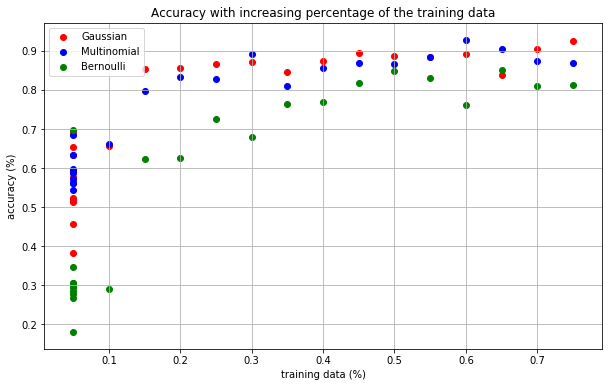

Run: 3
Gaussian
Training data in percent: 0.05	Correct: 100	Incorrect: 99	Accuracy: 0.50
Training data in percent: 0.05	Correct: 98	Incorrect: 101	Accuracy: 0.49
Training data in percent: 0.05	Correct: 76	Incorrect: 123	Accuracy: 0.38
Training data in percent: 0.05	Correct: 89	Incorrect: 110	Accuracy: 0.45
Training data in percent: 0.05	Correct: 69	Incorrect: 130	Accuracy: 0.35
Training data in percent: 0.05	Correct: 110	Incorrect: 89	Accuracy: 0.55
Training data in percent: 0.05	Correct: 87	Incorrect: 112	Accuracy: 0.44
Training data in percent: 0.05	Correct: 130	Incorrect: 69	Accuracy: 0.65
Training data in percent: 0.05	Correct: 115	Incorrect: 84	Accuracy: 0.58
Training data in percent: 0.05	Correct: 109	Incorrect: 90	Accuracy: 0.55
Training data in percent: 0.10	Correct: 137	Incorrect: 52	Accuracy: 0.72
Training data in percent: 0.15	Correct: 144	Incorrect: 34	Accuracy: 0.81
Training data in percent: 0.20	Correct: 131	Incorrect: 37	Accuracy: 0.78
Training data in percent: 0.25	Corr

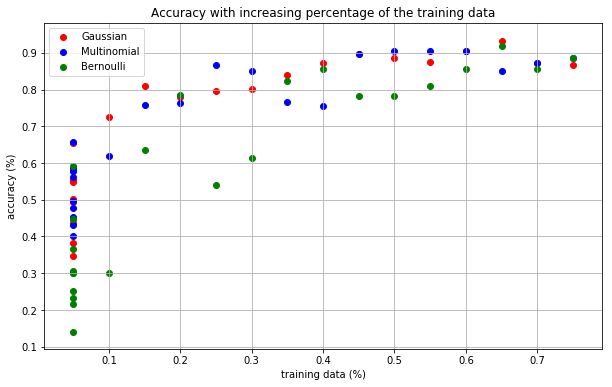

Run: 4
Gaussian
Training data in percent: 0.05	Correct: 83	Incorrect: 116	Accuracy: 0.42
Training data in percent: 0.05	Correct: 96	Incorrect: 103	Accuracy: 0.48
Training data in percent: 0.05	Correct: 91	Incorrect: 108	Accuracy: 0.46
Training data in percent: 0.05	Correct: 118	Incorrect: 81	Accuracy: 0.59
Training data in percent: 0.05	Correct: 117	Incorrect: 82	Accuracy: 0.59
Training data in percent: 0.05	Correct: 54	Incorrect: 145	Accuracy: 0.27
Training data in percent: 0.05	Correct: 109	Incorrect: 90	Accuracy: 0.55
Training data in percent: 0.05	Correct: 87	Incorrect: 112	Accuracy: 0.44
Training data in percent: 0.05	Correct: 108	Incorrect: 91	Accuracy: 0.54
Training data in percent: 0.05	Correct: 127	Incorrect: 72	Accuracy: 0.64
Training data in percent: 0.10	Correct: 152	Incorrect: 37	Accuracy: 0.80
Training data in percent: 0.15	Correct: 153	Incorrect: 25	Accuracy: 0.86
Training data in percent: 0.20	Correct: 143	Incorrect: 25	Accuracy: 0.85
Training data in percent: 0.25	Corr

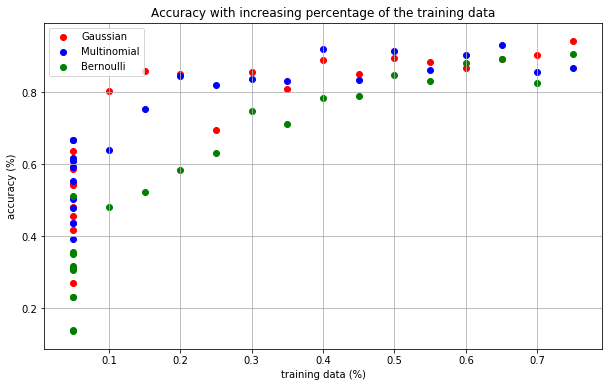

Run: 5
Gaussian
Training data in percent: 0.05	Correct: 119	Incorrect: 80	Accuracy: 0.60
Training data in percent: 0.05	Correct: 69	Incorrect: 130	Accuracy: 0.35
Training data in percent: 0.05	Correct: 74	Incorrect: 125	Accuracy: 0.37
Training data in percent: 0.05	Correct: 100	Incorrect: 99	Accuracy: 0.50
Training data in percent: 0.05	Correct: 121	Incorrect: 78	Accuracy: 0.61
Training data in percent: 0.05	Correct: 88	Incorrect: 111	Accuracy: 0.44
Training data in percent: 0.05	Correct: 113	Incorrect: 86	Accuracy: 0.57
Training data in percent: 0.05	Correct: 107	Incorrect: 92	Accuracy: 0.54
Training data in percent: 0.05	Correct: 120	Incorrect: 79	Accuracy: 0.60
Training data in percent: 0.05	Correct: 128	Incorrect: 71	Accuracy: 0.64
Training data in percent: 0.10	Correct: 143	Incorrect: 46	Accuracy: 0.76
Training data in percent: 0.15	Correct: 123	Incorrect: 55	Accuracy: 0.69
Training data in percent: 0.20	Correct: 152	Incorrect: 16	Accuracy: 0.90
Training data in percent: 0.25	Corr

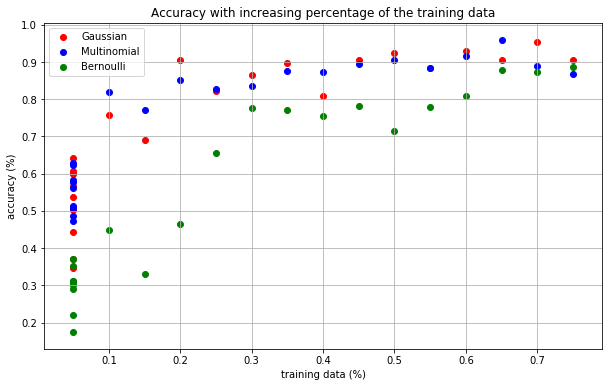

Run: 6
Gaussian
Training data in percent: 0.05	Correct: 104	Incorrect: 95	Accuracy: 0.52
Training data in percent: 0.05	Correct: 67	Incorrect: 132	Accuracy: 0.34
Training data in percent: 0.05	Correct: 115	Incorrect: 84	Accuracy: 0.58
Training data in percent: 0.05	Correct: 123	Incorrect: 76	Accuracy: 0.62
Training data in percent: 0.05	Correct: 84	Incorrect: 115	Accuracy: 0.42
Training data in percent: 0.05	Correct: 95	Incorrect: 104	Accuracy: 0.48
Training data in percent: 0.05	Correct: 52	Incorrect: 147	Accuracy: 0.26
Training data in percent: 0.05	Correct: 90	Incorrect: 109	Accuracy: 0.45
Training data in percent: 0.05	Correct: 88	Incorrect: 111	Accuracy: 0.44
Training data in percent: 0.05	Correct: 109	Incorrect: 90	Accuracy: 0.55
Training data in percent: 0.10	Correct: 115	Incorrect: 74	Accuracy: 0.61
Training data in percent: 0.15	Correct: 150	Incorrect: 28	Accuracy: 0.84
Training data in percent: 0.20	Correct: 126	Incorrect: 42	Accuracy: 0.75
Training data in percent: 0.25	Corr

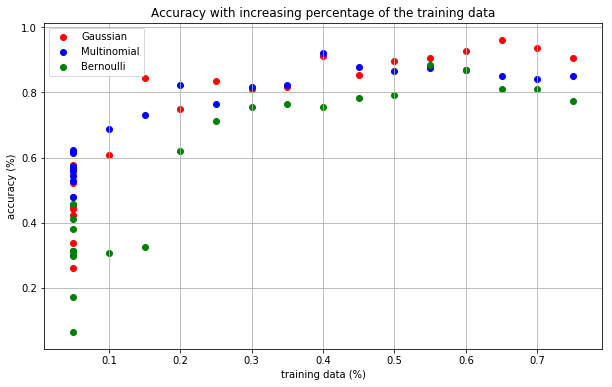

Run: 7
Gaussian
Training data in percent: 0.05	Correct: 58	Incorrect: 141	Accuracy: 0.29
Training data in percent: 0.05	Correct: 93	Incorrect: 106	Accuracy: 0.47
Training data in percent: 0.05	Correct: 101	Incorrect: 98	Accuracy: 0.51
Training data in percent: 0.05	Correct: 107	Incorrect: 92	Accuracy: 0.54
Training data in percent: 0.05	Correct: 141	Incorrect: 58	Accuracy: 0.71
Training data in percent: 0.05	Correct: 92	Incorrect: 107	Accuracy: 0.46
Training data in percent: 0.05	Correct: 93	Incorrect: 106	Accuracy: 0.47
Training data in percent: 0.05	Correct: 108	Incorrect: 91	Accuracy: 0.54
Training data in percent: 0.05	Correct: 100	Incorrect: 99	Accuracy: 0.50
Training data in percent: 0.05	Correct: 100	Incorrect: 99	Accuracy: 0.50
Training data in percent: 0.10	Correct: 121	Incorrect: 68	Accuracy: 0.64
Training data in percent: 0.15	Correct: 125	Incorrect: 53	Accuracy: 0.70
Training data in percent: 0.20	Correct: 144	Incorrect: 24	Accuracy: 0.86
Training data in percent: 0.25	Corr

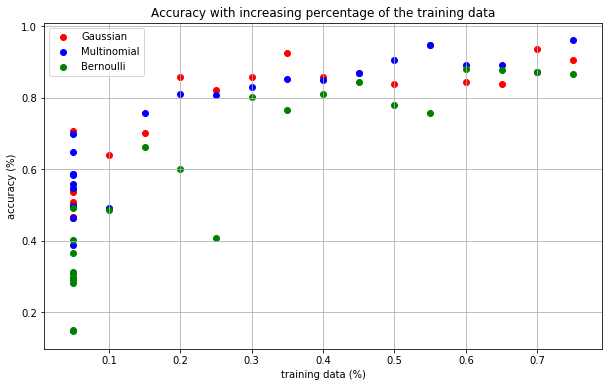

Run: 8
Gaussian
Training data in percent: 0.05	Correct: 99	Incorrect: 100	Accuracy: 0.50
Training data in percent: 0.05	Correct: 116	Incorrect: 83	Accuracy: 0.58
Training data in percent: 0.05	Correct: 107	Incorrect: 92	Accuracy: 0.54
Training data in percent: 0.05	Correct: 89	Incorrect: 110	Accuracy: 0.45
Training data in percent: 0.05	Correct: 105	Incorrect: 94	Accuracy: 0.53
Training data in percent: 0.05	Correct: 105	Incorrect: 94	Accuracy: 0.53
Training data in percent: 0.05	Correct: 108	Incorrect: 91	Accuracy: 0.54
Training data in percent: 0.05	Correct: 122	Incorrect: 77	Accuracy: 0.61
Training data in percent: 0.05	Correct: 138	Incorrect: 61	Accuracy: 0.69
Training data in percent: 0.05	Correct: 82	Incorrect: 117	Accuracy: 0.41
Training data in percent: 0.10	Correct: 128	Incorrect: 61	Accuracy: 0.68
Training data in percent: 0.15	Correct: 131	Incorrect: 47	Accuracy: 0.74
Training data in percent: 0.20	Correct: 142	Incorrect: 26	Accuracy: 0.85
Training data in percent: 0.25	Corr

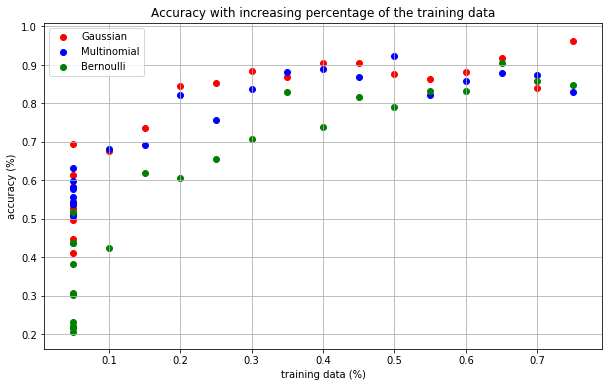

Run: 9
Gaussian
Training data in percent: 0.05	Correct: 141	Incorrect: 58	Accuracy: 0.71
Training data in percent: 0.05	Correct: 109	Incorrect: 90	Accuracy: 0.55
Training data in percent: 0.05	Correct: 88	Incorrect: 111	Accuracy: 0.44
Training data in percent: 0.05	Correct: 101	Incorrect: 98	Accuracy: 0.51
Training data in percent: 0.05	Correct: 100	Incorrect: 99	Accuracy: 0.50
Training data in percent: 0.05	Correct: 90	Incorrect: 109	Accuracy: 0.45
Training data in percent: 0.05	Correct: 98	Incorrect: 101	Accuracy: 0.49
Training data in percent: 0.05	Correct: 104	Incorrect: 95	Accuracy: 0.52
Training data in percent: 0.05	Correct: 105	Incorrect: 94	Accuracy: 0.53
Training data in percent: 0.05	Correct: 124	Incorrect: 75	Accuracy: 0.62
Training data in percent: 0.10	Correct: 139	Incorrect: 50	Accuracy: 0.74
Training data in percent: 0.15	Correct: 152	Incorrect: 26	Accuracy: 0.85
Training data in percent: 0.20	Correct: 138	Incorrect: 30	Accuracy: 0.82
Training data in percent: 0.25	Corr

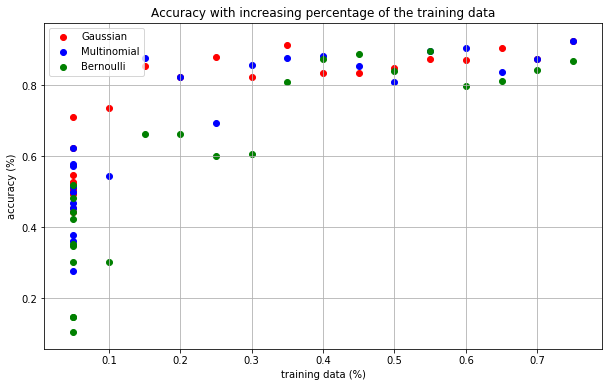

Run: 10
Gaussian
Training data in percent: 0.05	Correct: 115	Incorrect: 84	Accuracy: 0.58
Training data in percent: 0.05	Correct: 65	Incorrect: 134	Accuracy: 0.33
Training data in percent: 0.05	Correct: 118	Incorrect: 81	Accuracy: 0.59
Training data in percent: 0.05	Correct: 86	Incorrect: 113	Accuracy: 0.43
Training data in percent: 0.05	Correct: 129	Incorrect: 70	Accuracy: 0.65
Training data in percent: 0.05	Correct: 88	Incorrect: 111	Accuracy: 0.44
Training data in percent: 0.05	Correct: 62	Incorrect: 137	Accuracy: 0.31
Training data in percent: 0.05	Correct: 109	Incorrect: 90	Accuracy: 0.55
Training data in percent: 0.05	Correct: 102	Incorrect: 97	Accuracy: 0.51
Training data in percent: 0.05	Correct: 103	Incorrect: 96	Accuracy: 0.52
Training data in percent: 0.10	Correct: 123	Incorrect: 66	Accuracy: 0.65
Training data in percent: 0.15	Correct: 134	Incorrect: 44	Accuracy: 0.75
Training data in percent: 0.20	Correct: 128	Incorrect: 40	Accuracy: 0.76
Training data in percent: 0.25	Cor

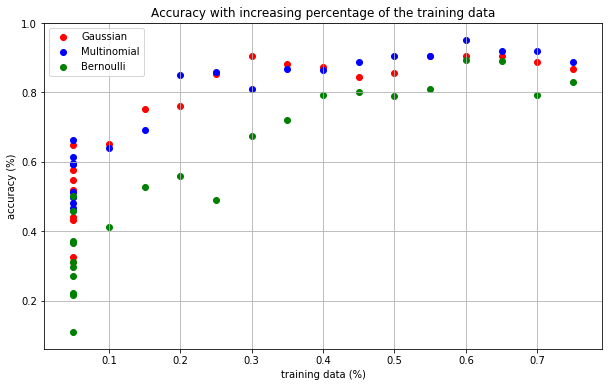

Performance Gaussian: 0.8995042672123109
Performance Multinomial: 0.8892754302039307
Performance Bernoulli: 0.846434729523111


In [10]:
def train_and_test_classificator(classificator_name, classificator, percentage, nr_of_low_percent_train_data_runs):
    result_classificator = []
    formatter = "{:0.2f}"
    if PRINT_RESULTS_FOR_SINGLE_RUN:
        print(classificator_name)
    while percentage <= 0.80:
        X_Training, Y_Training, X_Test, Y_Test = get_classification_ready_data(percentage)
        classificator.fit(X_Training, Y_Training)
        results = classificator.predict(X_Test)

        i = 0
        miss_classifications = 0
        correct_classifications = 0
        for result in results:
            if result == Y_Test[i]:
                correct_classifications += 1
            else:
                miss_classifications += 1
            i += 1

        accuracy = correct_classifications / len(results)
        result_classificator.append([percentage, accuracy])

        if PRINT_RESULTS_FOR_SINGLE_RUN:
            print("Training data in percent: " + str(formatter.format(percentage)), end="\t")
            print("Correct: " + str(correct_classifications), end="\t")
            print("Incorrect: " + str(miss_classifications), end="\t")
            print("Accuracy: " + str(formatter.format(accuracy)))
        nr_of_low_percent_train_data_runs -= 1
        if nr_of_low_percent_train_data_runs < 1:
            percentage += 0.05

    return result_classificator
    
if __name__ == '__main__':
    nr_of_epochs = 10
    nr_of_low_percent_train_data_runs = 10
    percentage = 0.05
    
    classificators = { "Gaussian": GaussianNB(), "Multinomial": MultinomialNB(), "Bernoulli": BernoulliNB() }
    
    plot_data_whole_runs = { "Gaussian" : [], "Multinomial": [], "Bernoulli": [] }
    for i in range(nr_of_epochs):
        print("Run: " + str(i + 1))
        plot_data = {}
        for key, value in classificators.items():
            plot_data_classificator = train_and_test_classificator(key, value, percentage, nr_of_low_percent_train_data_runs)
            plot_data[key] = numpy.array(plot_data_classificator)
            plot_data_whole_runs[key].append(numpy.array(plot_data_classificator))
        if PRINT_RESULTS_FOR_SINGLE_RUN:
            plot_classification_results(plot_data)
            
    print_results_of_all_runs(plot_data_whole_runs)